In [1]:
!nvidia-smi

Sun Apr 14 17:50:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.72                 Driver Version: 536.45       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8               3W /  95W |    165MiB /  8188MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# # Install xarray
!pip install xarray==2023.7.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.4 MB/s eta 0:00:00a 0:00:01


In [1]:
!pip install segment-geospatial leafmap localtileserver

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
!pip install jupyter-server-proxy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
# import leafmap
import leafmap.leafmap as leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps,show_image, overlay_images

In [2]:
m = leafmap.Map(center=[29.676840, -95.369222], zoom=19)
m.add_basemap("SATELLITE")
m

Map(center=[29.67684, -95.369222], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [3]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-95.3704, 29.6762, -95.368, 29.6775]
print(bbox)

[-95.3704, 29.6762, -95.368, 29.6775]


Downloaded image 01/40
Downloaded image 02/40
Downloaded image 03/40
Downloaded image 04/40
Downloaded image 05/40
Downloaded image 06/40
Downloaded image 07/40
Downloaded image 08/40
Downloaded image 09/40
Downloaded image 10/40
Downloaded image 11/40
Downloaded image 12/40
Downloaded image 13/40
Downloaded image 14/40
Downloaded image 15/40
Downloaded image 16/40
Downloaded image 17/40
Downloaded image 18/40
Downloaded image 19/40
Downloaded image 20/40
Downloaded image 21/40
Downloaded image 22/40
Downloaded image 23/40
Downloaded image 24/40
Downloaded image 25/40
Downloaded image 26/40
Downloaded image 27/40
Downloaded image 28/40
Downloaded image 29/40
Downloaded image 30/40
Downloaded image 31/40
Downloaded image 32/40
Downloaded image 33/40
Downloaded image 34/40
Downloaded image 35/40
Downloaded image 36/40
Downloaded image 37/40
Downloaded image 38/40
Downloaded image 39/40
Downloaded image 40/40
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


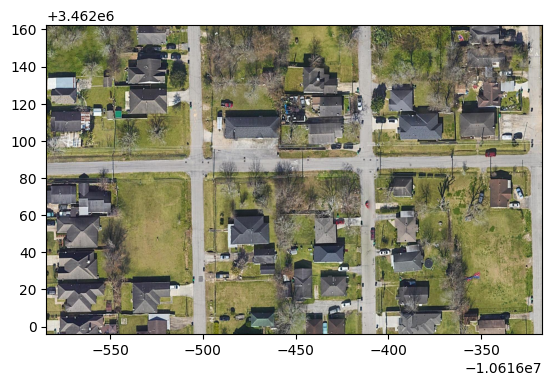

In [4]:
## Download the image of the iou drawn as .tif and show
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source="Satellite", overwrite=True)

with rasterio.open(image) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax)

In [6]:
m.layers[-1].visible = False  
m.add_raster(image, layer_name="My Raster Layer")
m

Map(bottom=867710.0, center=[29.675823492453357, -95.35780906677248], controls=(ZoomControl(options=['position…

In [14]:
from localtileserver import get_leaflet_tile_layer, TileClient## turn off the basemap
import rasterio
from rasterio.plot import show
from ipyleaflet import Map, ImageOverlay
src = rasterio.open('/workspaces/CSGY6613-Project/satellite.tif')
client = TileClient(src)
t = get_leaflet_tile_layer(client)
m.add(t)
m

Map(bottom=55514104.0, center=[29.67684, -95.369222], controls=(ZoomControl(options=['position', 'zoom_in_text…

## SAM

Load SAM pretrain model

In [31]:
ckpt="/workspaces/CSGY6613-Project/checkpoints/sam_vit_h_4b8939.pth"
sam = SamGeo(
    model_type="vit_h",
    checkpoint=ckpt,
    sam_kwargs=None,
)

Automatic mask generation

In [32]:
mask = "segment.tif"   ## binary mask
# sam.generate(
#     image, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
# )
sam.generate(image,output=mask,foreground=True,unique=True)

Display binary mask

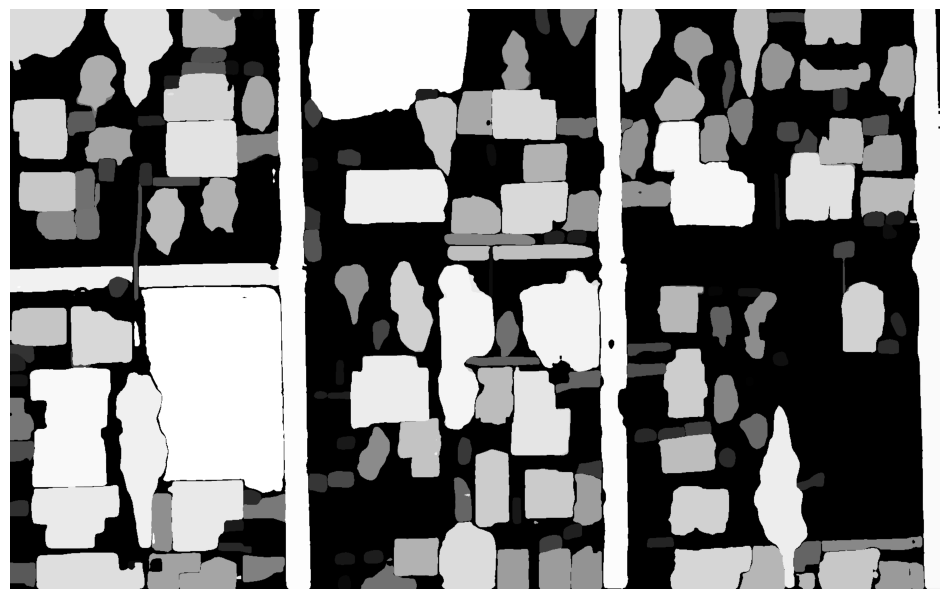

In [33]:
sam.show_masks(cmap="binary_r")

Display annotation image

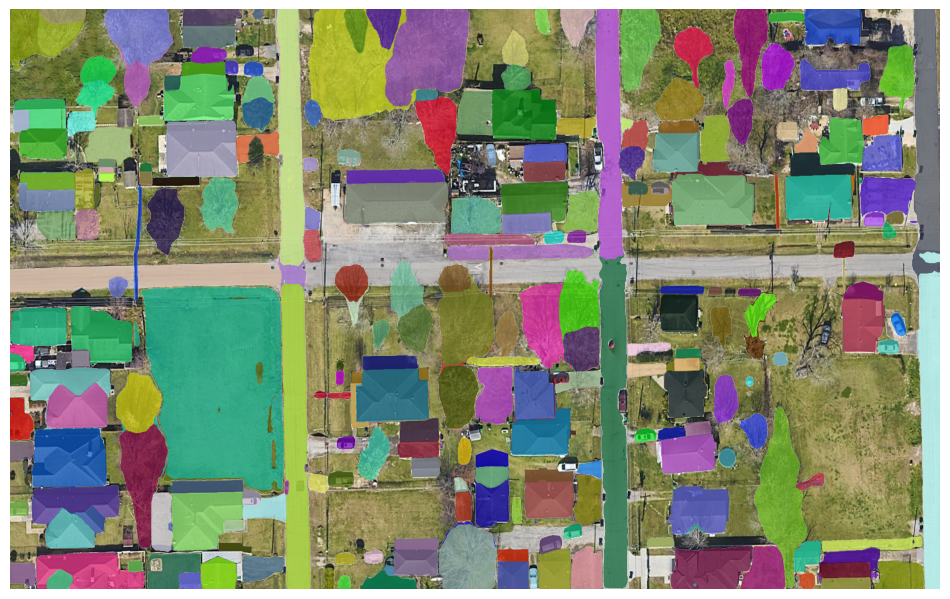

In [34]:
sam.show_anns(axis="off",alpha=0.7,output="annotation.tif")

Compare the original image and the segmententation results


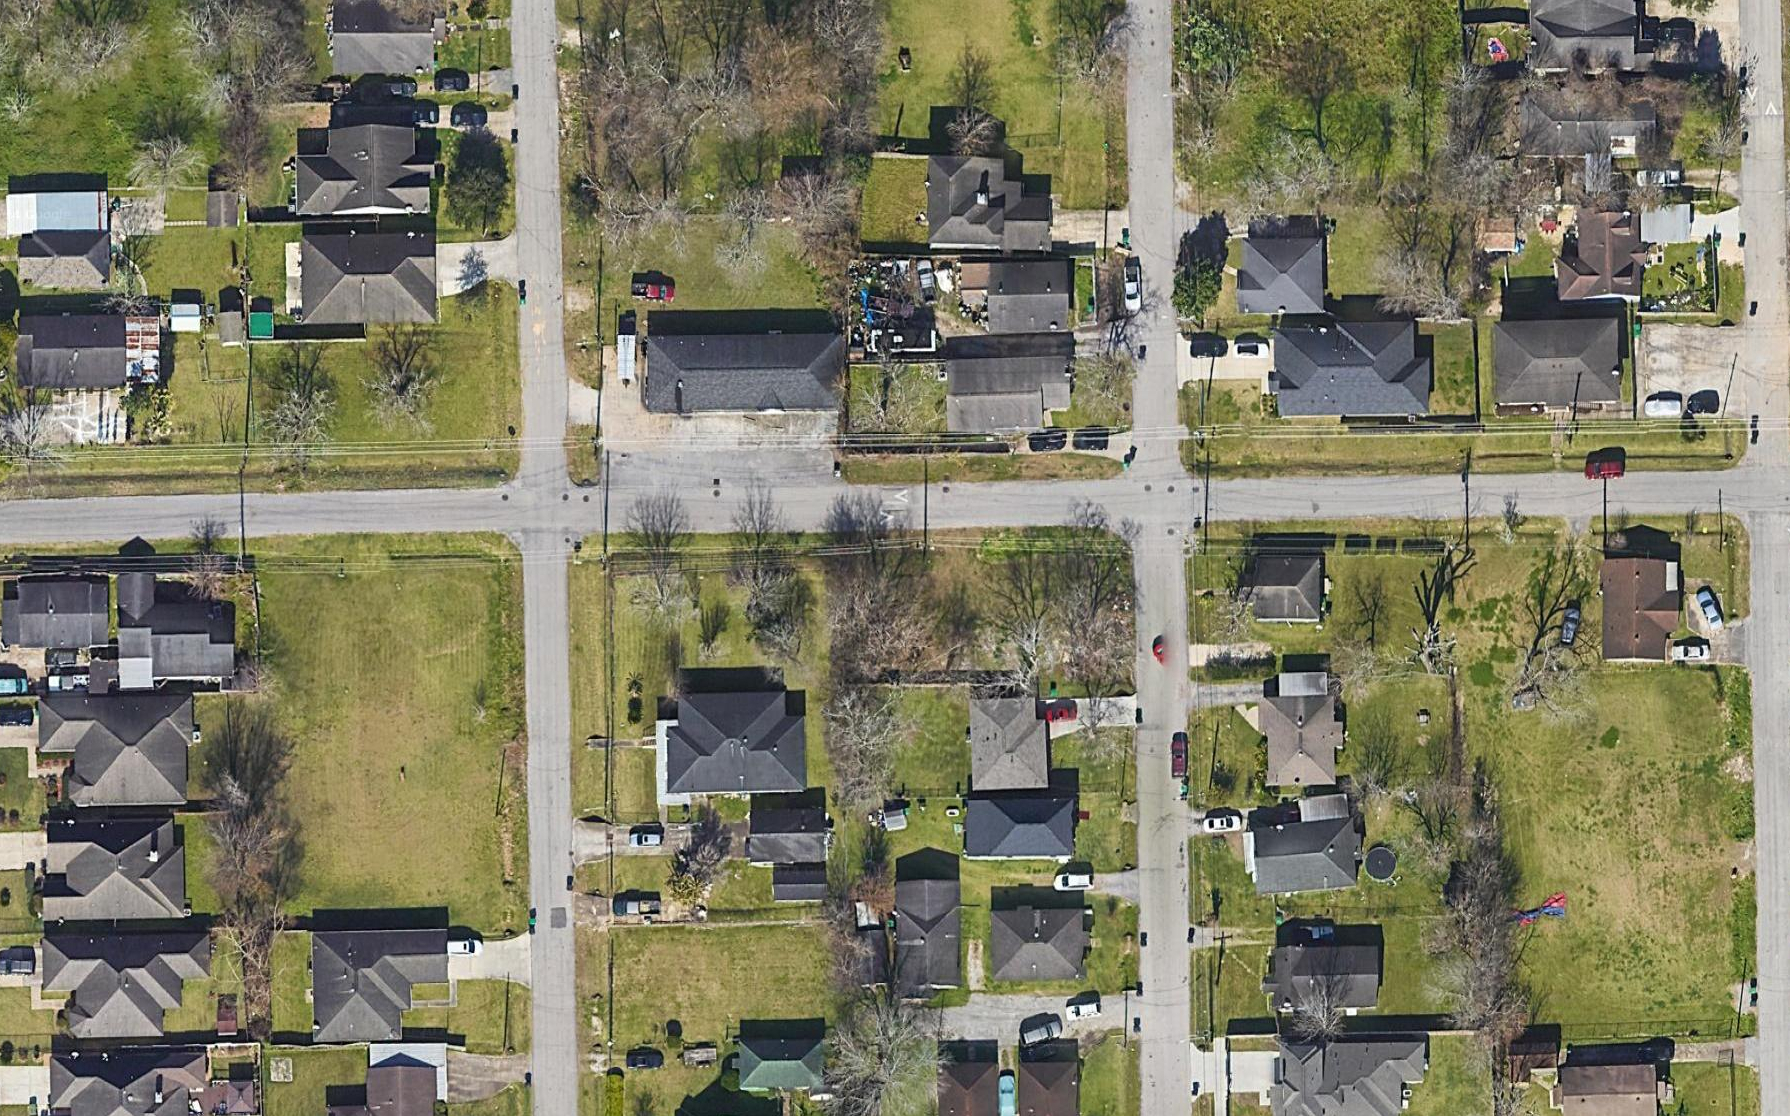
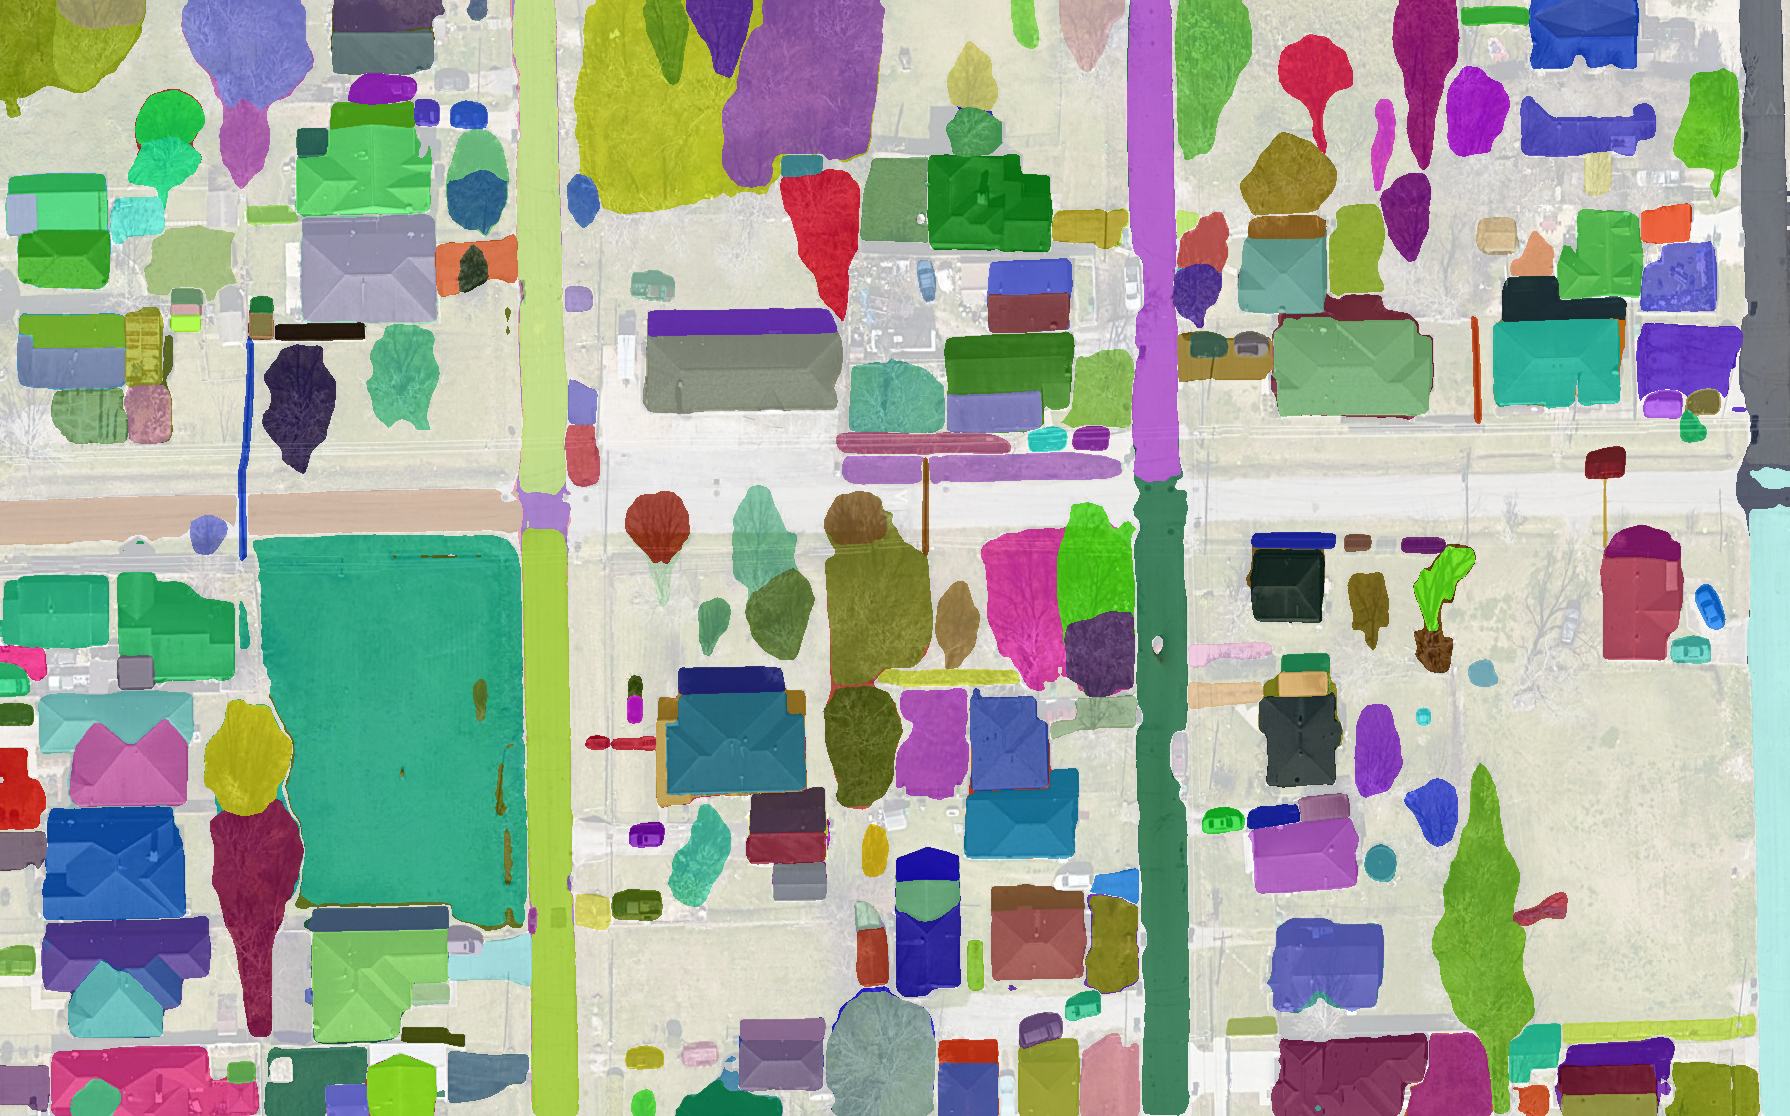

In [35]:
leafmap.image_comparison("satellite.tif", "annotation.tif", label1="Satellite", label2="Image Segmentation")

Add the segmentation results as a new layer on the interactive map

In [40]:
m.add_raster("annotation.tif",alpha=0.5,layer_name="Mask")
m

Map(bottom=27757200.0, center=[29.67685, -95.3692], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Convert the mask to verctor data

In [36]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

In [37]:
shapefile = "segment.shp"
sam.tiff_to_vector(mask, shapefile)

In [38]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(bottom=27757337.0, center=[29.67621034007189, -95.36886781454088], controls=(ZoomControl(options=['positio…

In [39]:
m.add_raster("annotation.tif",alpha=0.5,layer_name="Mask")
m

Map(bottom=27757337.0, center=[29.67621034007189, -95.36886781454088], controls=(ZoomControl(options=['positio…